In [1]:
import numpy as np
from scipy.special import expit, logit
from shap.maskers import Independent
import models
from plots import plot_shap_value_distribution, plot_shap_partial_dependence, plot_shap_values_stacked, \
    plot_shap_values_hierarchically_clustered, plot_functions
import shap
import matplotlib.pyplot as plt
import pickle
from types import SimpleNamespace
%matplotlib inline
shap.initjs()

# Move Soft Decision Boundary

## Create Models

In [2]:
clf = SimpleNamespace()
clf.a = models.PredictLogOddsMethodClassifier(lambda X: X[:,0] * 50)
clf.b = models.PredictLogOddsMethodClassifier(lambda X: (X[:,0] - 0.15) * 50)

In [3]:
x_from = -1
x_to = 1
feature_names = ['x1']
num_samples = 500
x1 = np.linspace(x_from, x_to, num_samples)
X = np.reshape(x1, (num_samples, len(feature_names)))

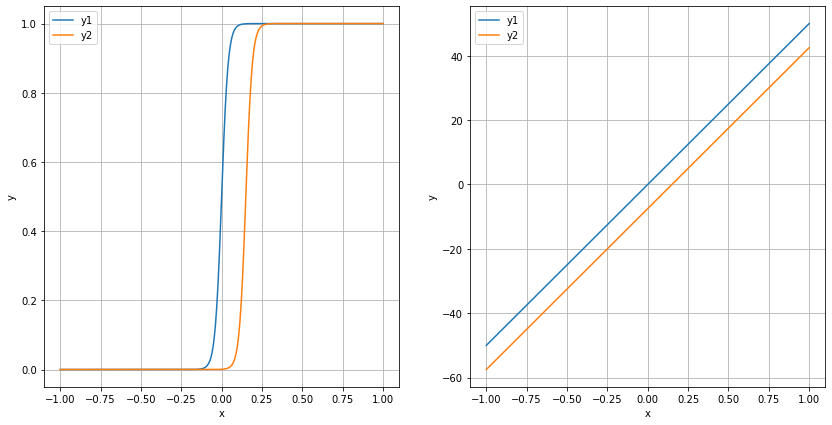

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
plot_functions(X, clf.a, clf.b, method='proba', ax=axs[0])
plot_functions(X, clf.a, clf.b, method='log_odds', ax=axs[1])
plt.show()

In [5]:
diff = SimpleNamespace()
diff.a_and_b_diff = models.C1AndC2Different(clf.a, clf.b)
diff.a_pos_and_b_neg = models.C1PositiveAndC2Negative(clf.a, clf.b)
diff.a_neg_and_b_pos = models.C1PositiveAndC2Negative(clf.b, clf.a)
diff.log_odds_ratio = models.LogOddsRatio(clf.a, clf.b)

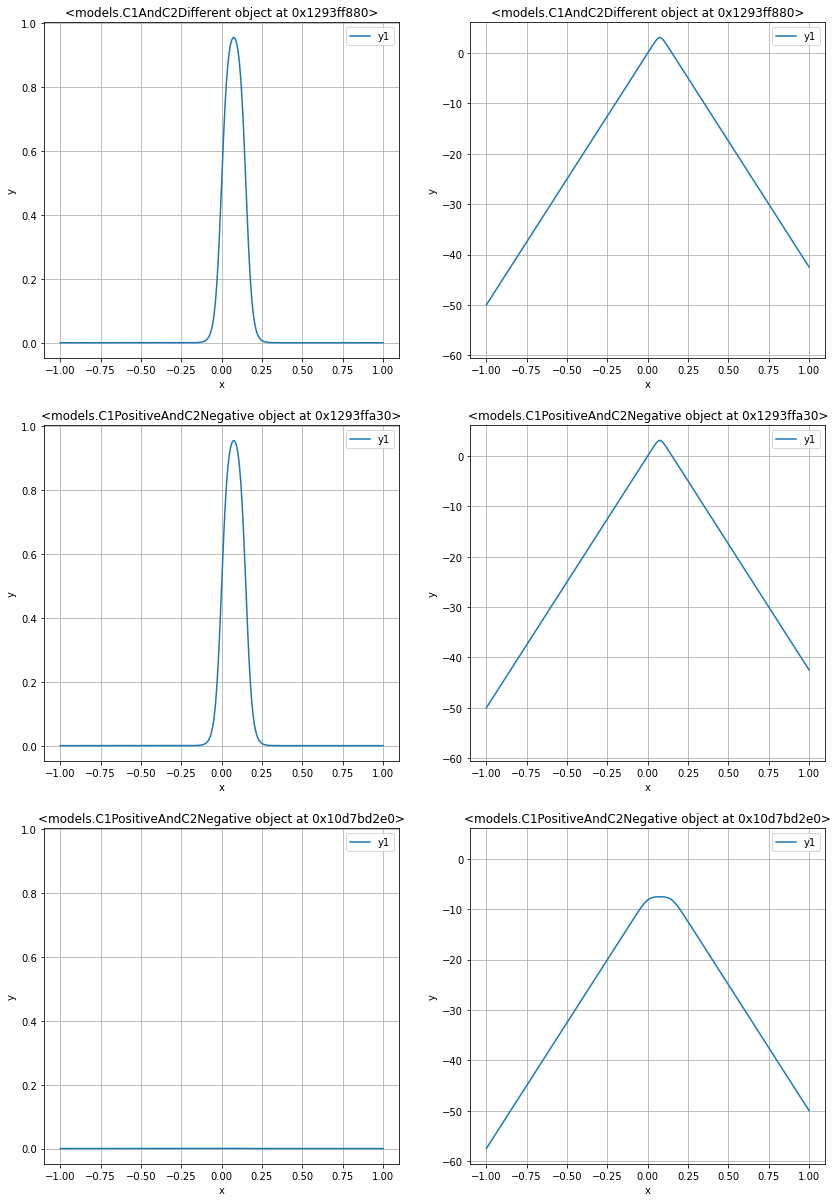

In [6]:
fig = plt.figure(figsize=(14, 21))
ax_l = fig.add_subplot(3, 2, 1)
ax_r = fig.add_subplot(3, 2, 2)
plot_functions(X, diff.a_and_b_diff, method='proba', ax=ax_l)
plot_functions(X, diff.a_and_b_diff, method='log_odds', ax=ax_r)
plot_functions(X, diff.a_pos_and_b_neg, method='proba', ax=fig.add_subplot(3, 2, 3, sharey=ax_l))
plot_functions(X, diff.a_pos_and_b_neg, method='log_odds', ax=fig.add_subplot(3, 2, 4, sharey=ax_r))
plot_functions(X, diff.a_neg_and_b_pos, method='proba', ax=fig.add_subplot(3, 2, 5, sharey=ax_l))
plot_functions(X, diff.a_neg_and_b_pos, method='log_odds', ax=fig.add_subplot(3, 2, 6, sharey=ax_r))
plt.show()

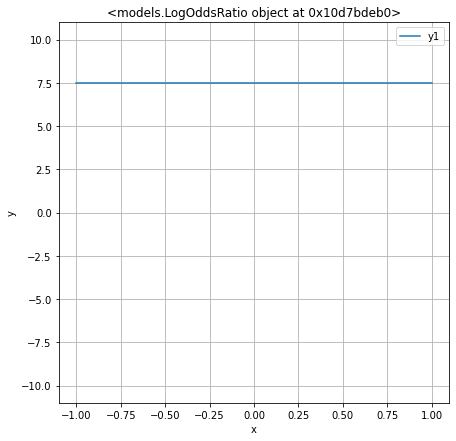

In [7]:
plot_functions(X, diff.log_odds_ratio, method='log_odds', ylim=(-11, 11))

## Generate Explanations

In [8]:
def explain(function):
    predict_pos = lambda X: function(X)[:, 1]
    masker = Independent(data=X)
    explainer = shap.Explainer(predict_pos, masker, feature_names=feature_names)
    shap_values = explainer(X)
    #shap_values.display_data = display_data
    shap_values.expected_value = np.mean(predict_pos(X))
    return shap_values

In [9]:
expl = SimpleNamespace()
expl.proba = SimpleNamespace(**dict([(name, explain(model.predict_proba)) for name, model in (vars(clf) | vars(diff)).items() if hasattr(model, 'predict_proba')]))
expl.log_odds = SimpleNamespace(**dict([(name, explain(model.predict_log_odds)) for name, model in (vars(clf) | vars(diff)).items() if hasattr(model, 'predict_log_odds')]))

## Analyze

### SHAP Value Distribution

#### Probability Space

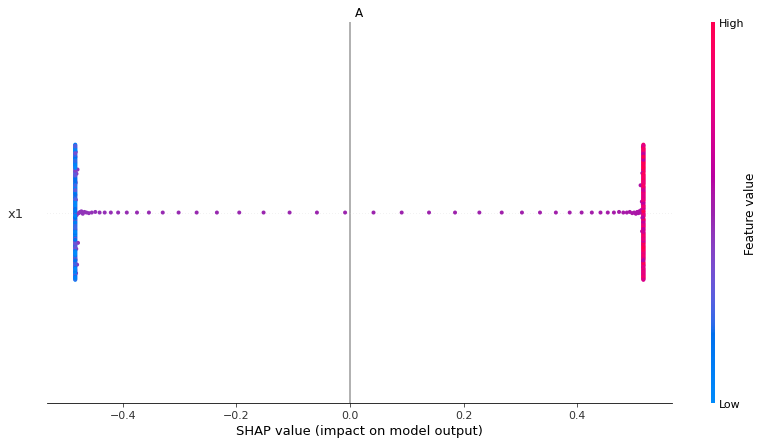

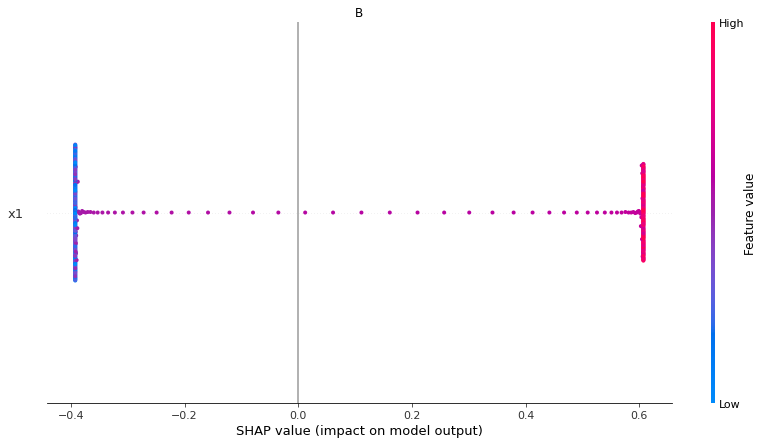

In [10]:
plot_shap_value_distribution(expl.proba.a, 'A')
plot_shap_value_distribution(expl.proba.b, 'B')

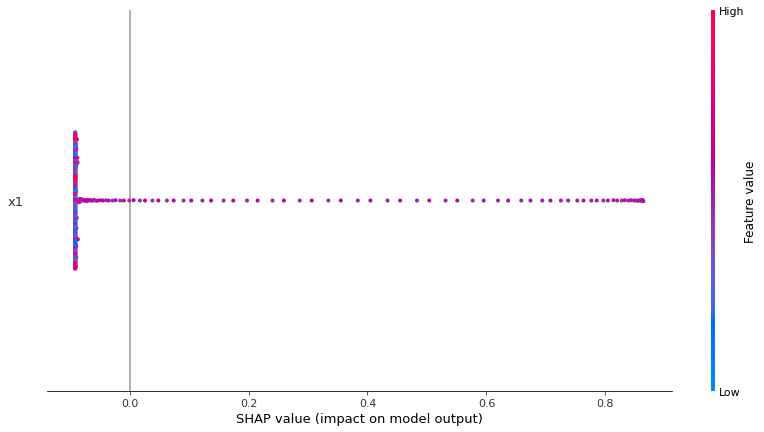

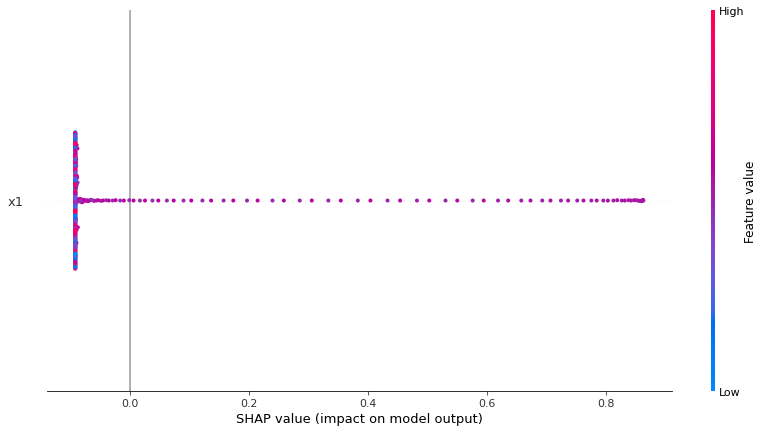

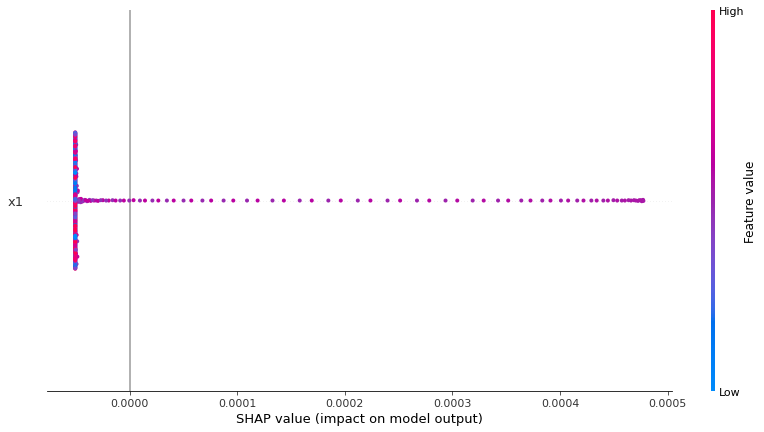

In [11]:
plot_shap_value_distribution(expl.proba.a_and_b_diff)
plot_shap_value_distribution(expl.proba.a_pos_and_b_neg)
plot_shap_value_distribution(expl.proba.a_neg_and_b_pos)

#### Margin Space

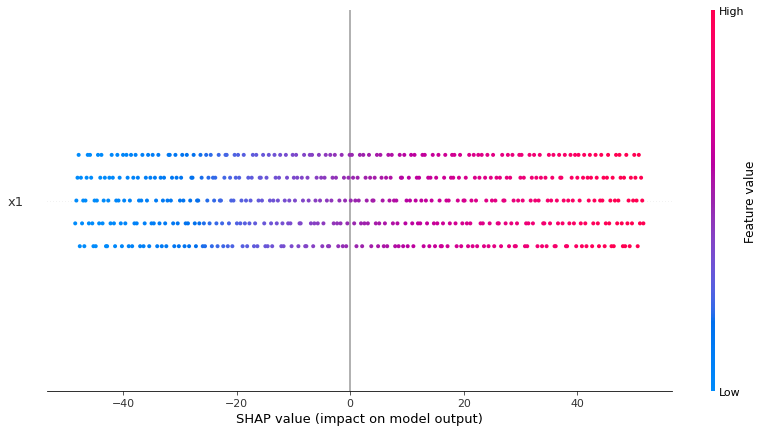

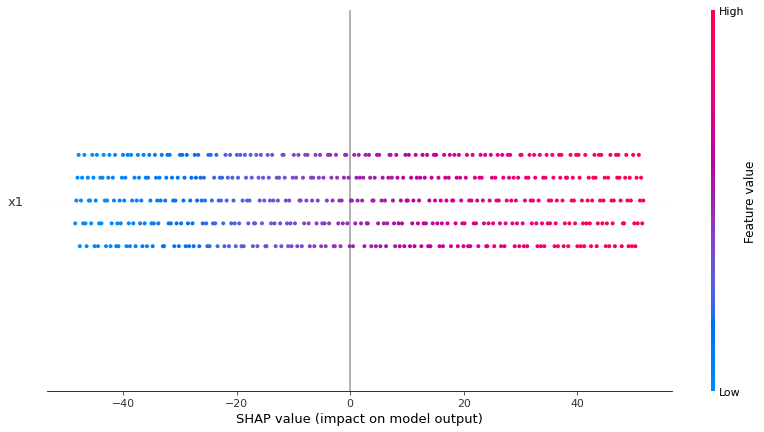

In [12]:
plot_shap_value_distribution(expl.log_odds.a)
plot_shap_value_distribution(expl.log_odds.b)

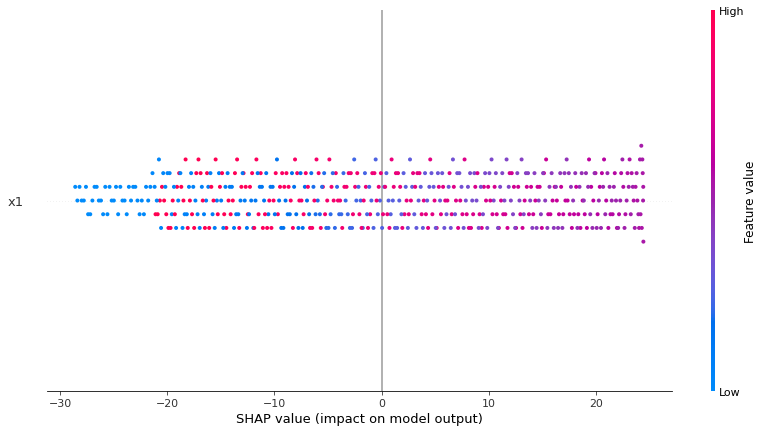

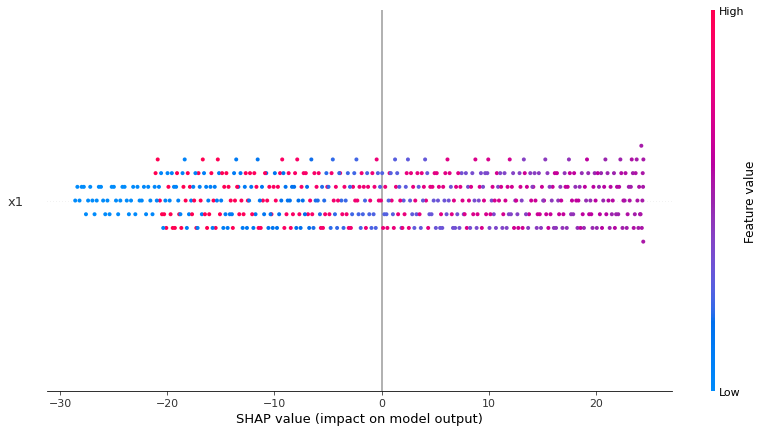

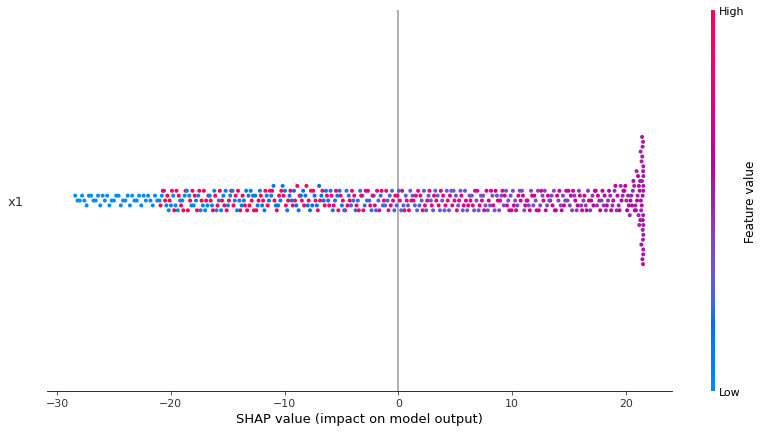

In [13]:
plot_shap_value_distribution(expl.log_odds.a_and_b_diff)
plot_shap_value_distribution(expl.log_odds.a_pos_and_b_neg)
plot_shap_value_distribution(expl.log_odds.a_neg_and_b_pos)

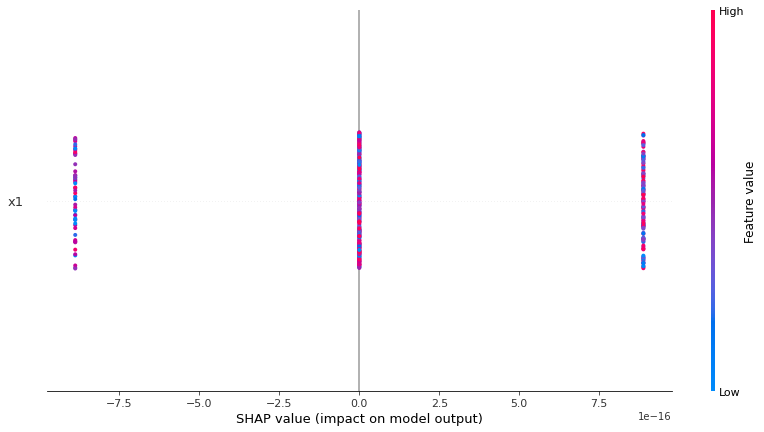

In [14]:
plot_shap_value_distribution(expl.log_odds.log_odds_ratio)

### Features' Partial Dependence Plots

#### Probability Space

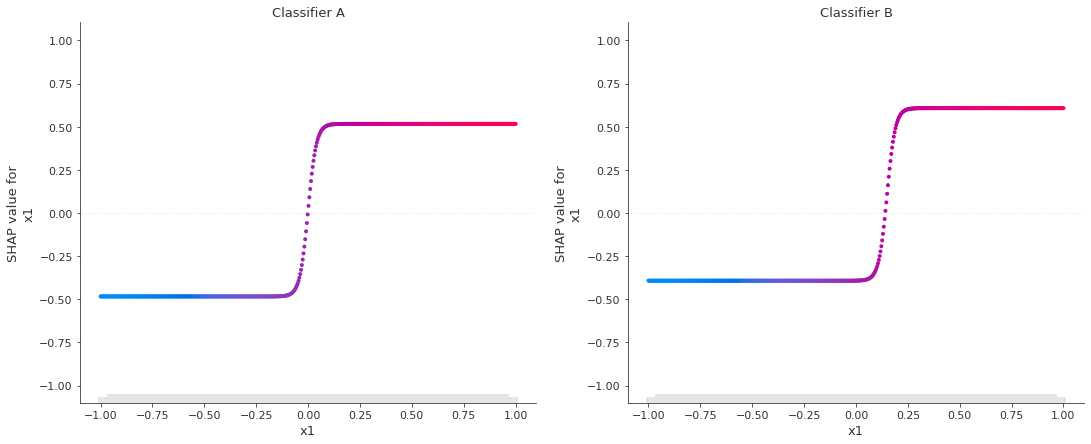

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(expl.proba.a, feature_names[0], 'Classifier A', (-1, 1), axs[0])
plot_shap_partial_dependence(expl.proba.b, feature_names[0], 'Classifier B', (-1, 1), axs[1])
plt.show()

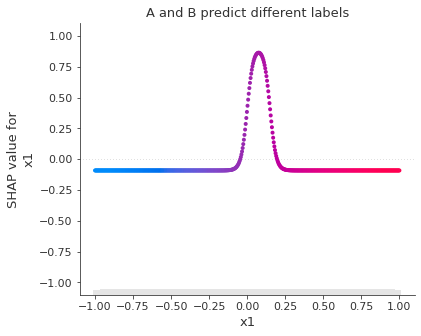

In [16]:
plot_shap_partial_dependence(expl.proba.a_and_b_diff, feature_names[0], 'A and B predict different labels', (-1, 1))

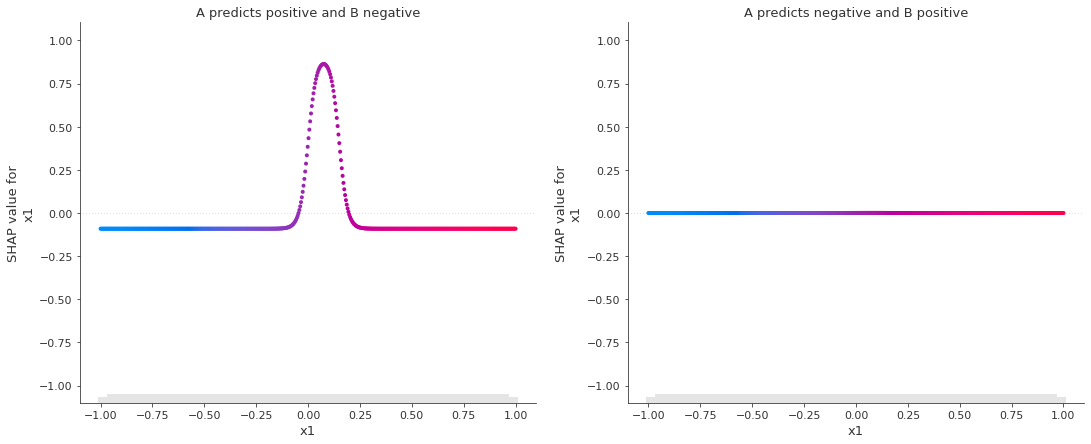

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(expl.proba.a_pos_and_b_neg, feature_names[0], 'A predicts positive and B negative', (-1, 1), axs[0])
plot_shap_partial_dependence(expl.proba.a_neg_and_b_pos, feature_names[0], 'A predicts negative and B positive', (-1, 1), axs[1])
plt.show()

#### Margin Space

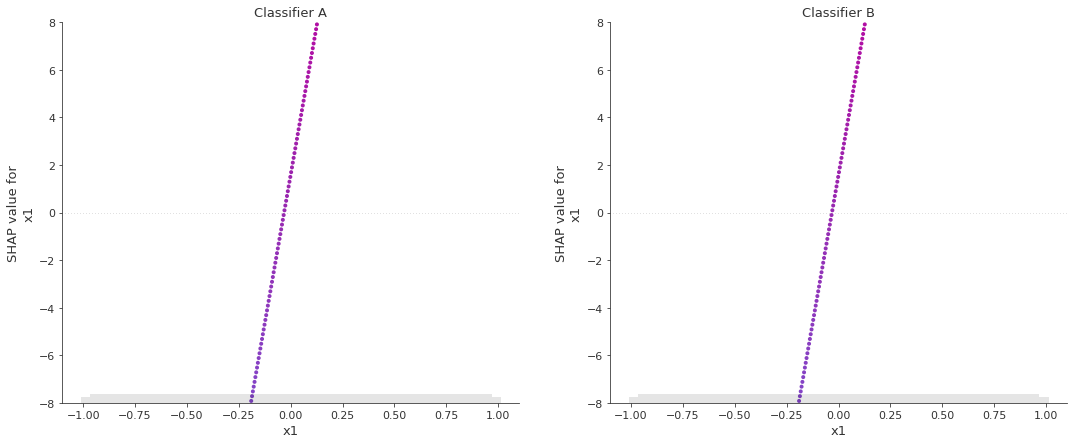

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(expl.log_odds.a, feature_names[0], 'Classifier A', (-8, 8), axs[0])
plot_shap_partial_dependence(expl.log_odds.b, feature_names[0], 'Classifier B', (-8, 8), axs[1])
plt.show()

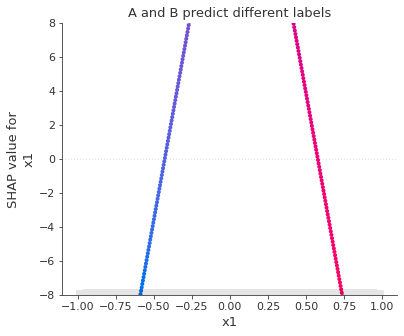

In [19]:
plot_shap_partial_dependence(expl.log_odds.a_and_b_diff, feature_names[0], 'A and B predict different labels', (-8, 8))

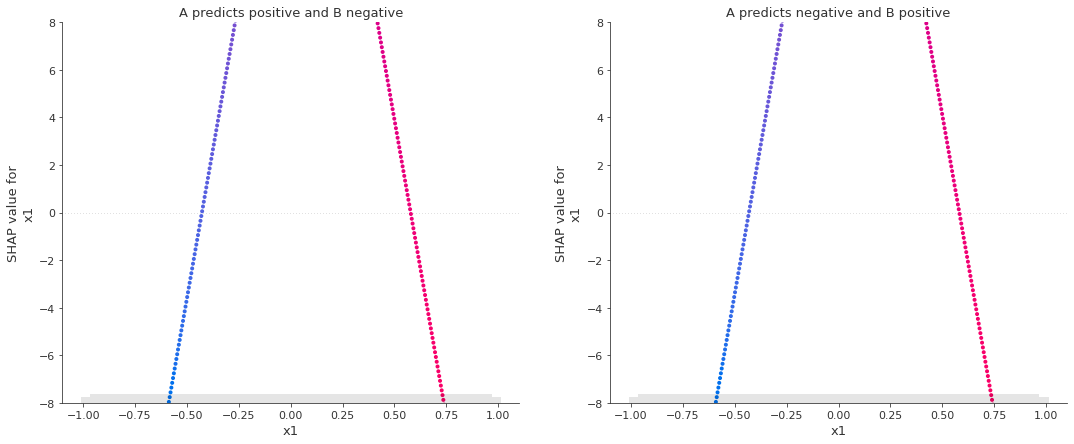

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(expl.log_odds.a_pos_and_b_neg, feature_names[0], 'A predicts positive and B negative', (-8, 8), axs[0])
plot_shap_partial_dependence(expl.log_odds.a_neg_and_b_pos, feature_names[0], 'A predicts negative and B positive', (-8, 8), axs[1])
plt.show()

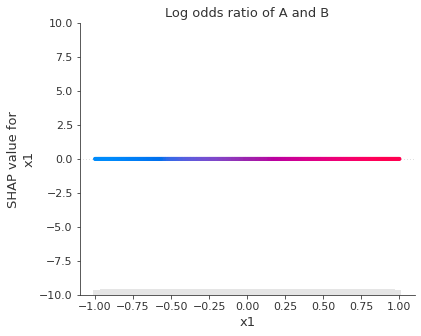

In [21]:
plot_shap_partial_dependence(expl.log_odds.log_odds_ratio, feature_names[0], 'Log odds ratio of A and B', (-10, 10))

### Stacked SHAP Explanations, Clustered by Similarity

#### Probability Space

In [22]:
ordering = plot_shap_values_stacked(expl.proba.a, 'Classifier A')
plot_shap_values_stacked(expl.proba.b, 'Classifier B', ordering=ordering);

In [23]:
plot_shap_values_stacked(expl.proba.a_and_b_diff, 'A and B predict different labels')
plot_shap_values_stacked(expl.proba.a_pos_and_b_neg, 'A predicts positive and B negative')
plot_shap_values_stacked(expl.proba.a_neg_and_b_pos, 'A predicts negative and B positive');

#### Margin Space

In [24]:
ordering = plot_shap_values_stacked(expl.log_odds.a, 'Classifier A')
plot_shap_values_stacked(expl.log_odds.b, 'Classifier B', ordering=ordering);

In [25]:
plot_shap_values_stacked(expl.log_odds.a_and_b_diff, 'A and B predict different labels')
plot_shap_values_stacked(expl.log_odds.a_pos_and_b_neg, 'A predicts positive and  negative')
plot_shap_values_stacked(expl.log_odds.a_neg_and_b_pos, 'A predicts negative and B positive');

In [26]:
plot_shap_values_stacked(expl.log_odds.log_odds_ratio, 'Log odds ratio of A and B');

### Hierarchically Clustered SHAP Values

#### Probability Space

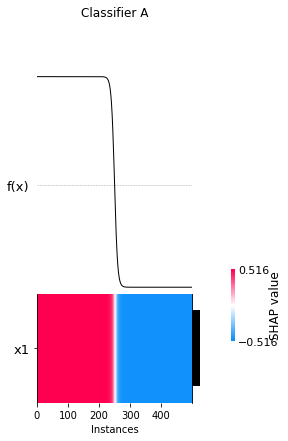

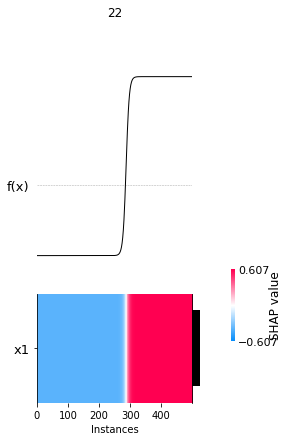

In [27]:
plot_shap_values_hierarchically_clustered(expl.proba.a, 'Classifier A')
plot_shap_values_hierarchically_clustered(expl.proba.b, '22')

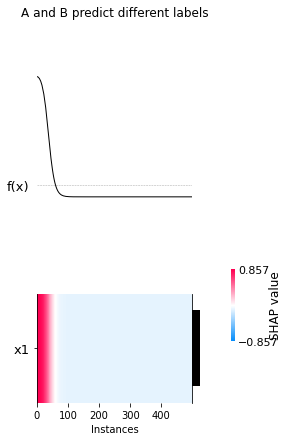

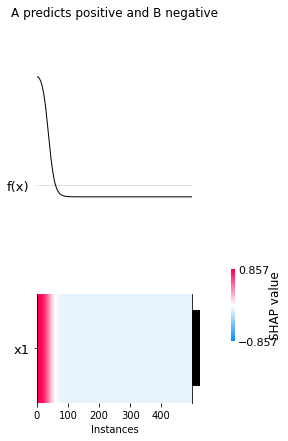

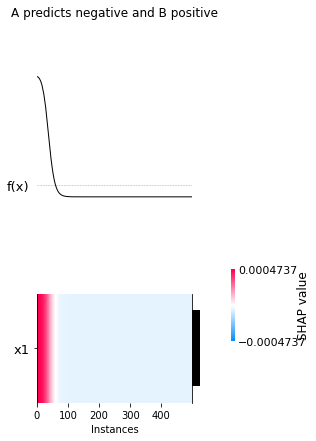

In [28]:
plot_shap_values_hierarchically_clustered(expl.proba.a_and_b_diff, 'A and B predict different labels')
plot_shap_values_hierarchically_clustered(expl.proba.a_pos_and_b_neg, 'A predicts positive and B negative')
plot_shap_values_hierarchically_clustered(expl.proba.a_neg_and_b_pos, 'A predicts negative and B positive')

#### Margin Space

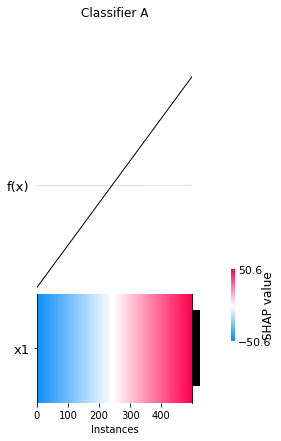

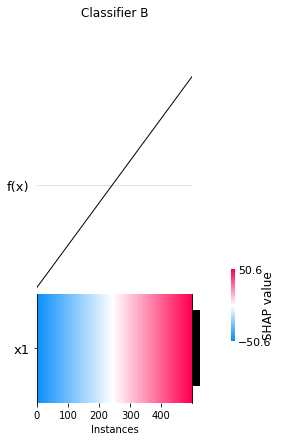

In [29]:
plot_shap_values_hierarchically_clustered(expl.log_odds.a, 'Classifier A')
plot_shap_values_hierarchically_clustered(expl.log_odds.b, 'Classifier B')

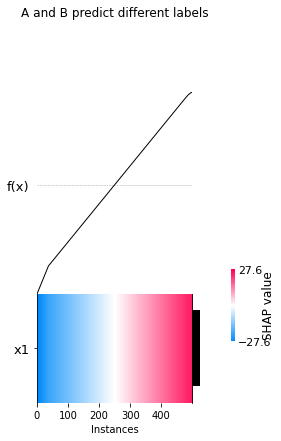

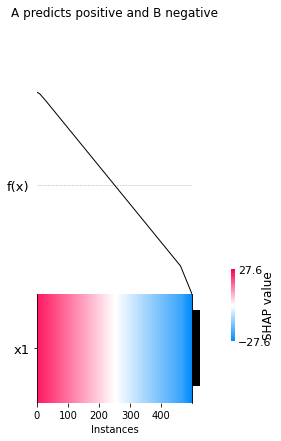

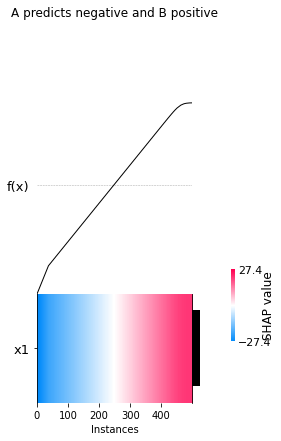

In [30]:
plot_shap_values_hierarchically_clustered(expl.log_odds.a_and_b_diff, 'A and B predict different labels')
plot_shap_values_hierarchically_clustered(expl.log_odds.a_pos_and_b_neg, 'A predicts positive and B negative')
plot_shap_values_hierarchically_clustered(expl.log_odds.a_neg_and_b_pos, 'A predicts negative and B positive')

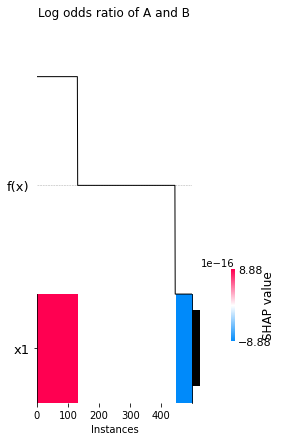

In [31]:
plot_shap_values_hierarchically_clustered(expl.log_odds.log_odds_ratio, 'Log odds ratio of A and B')